In [1]:
import database

/media/sf_dd/ehhapp-formulary2/views.py:3: ExtDeprecationWarning: Importing flask.ext.login is deprecated, use flask_login instead.
  import flask.ext.login as flask_login


In [2]:
test1 = MedicationRecord(
    id=111111,
    name="Acetaminophen",
    common_name="tylenol",
    transactions=[MedicationRecord.transaction(
        date=datetime.datetime(2017,12,4),
        price="3.78",
        qty=10)
        ],
    dosage="2x per 4 hours",
    admin="PO",
    category="debug",
    prescribable=False,
    aliases = None
    )
test2 = MedicationRecord(
    id=222222,
    name="Ibuprofen",
    common_name="Motrin",
    transactions=[MedicationRecord.transaction(
        date=datetime.datetime(2017,12,2),
        price="5.68",
        qty=24)
        ],
    dosage="2x per 8 hours",
    admin="PO",
    category="debug",
    prescribable=False,
    aliases = None
    )
test3 = MedicationRecord(
    id=333333,
    name="Acetylsalicylic acid",
    common_name="Aspirin",
    transactions=[MedicationRecord.transaction(
        date=datetime.datetime(2017,12,1),
        price="2.54",
        qty=20)
        ],
    dosage="once daily",
    admin="PO",
    category="important",
    prescribable=False,
    aliases = None
    )
test4 = MedicationRecord(
    id=333333,
    name="Acetylsalicylic acid",
    common_name="Aspirin",
    transactions=[MedicationRecord.transaction(
        date=datetime.datetime(2017,12,2),
        price="8.39",
        qty=90)
        ],
    dosage="once daily",
    admin="PO",
    category="important",
    prescribable=False,
    aliases = None
    )

In [4]:
database.save_persistent_record(test1)
database.save_persistent_record(test2)
database.save_persistent_record(test3)
database.save_persistent_record(test4)

<PersistentMedication 3>

In [6]:
database.get_all_medication_records()

[<MedicationRecord, id=111111, name=Acetaminophen, common_name=tylenol>,
 <MedicationRecord, id=222222, name=Ibuprofen, common_name=Motrin>,
 <MedicationRecord, id=333333, name=Acetylsalicylic acid, common_name=Aspirin>]

In [5]:
#!/usr/bin/env python
'''
Description: outputs desired quantity and cost data in .xlsx format
Inputs: persistant database with medicine list information
Output: excel file in desired format in .xlsx format
11/28/17 Brian Cho
'''

import pandas as pd
import invoicerecord
import database as medListDB

## Assume meds is list of MedicationRecord
medsList = medListDB.get_all_medication_records()	#import meds list from database

## Extract desired data in one loop from medsList
indexList = []
medInfoData = []
transactionHistoryData = []
for i in medsList:
	# Create list of index using id numbers from medsList
	# Will assume unique id nubmers to use as identifiers in database
	indexList.append(i.id)
	# Extract med info metadata
	medInfoData.append([i.name, i.category])
	# Extract transaction history data
	transactionHistoryData.append(i.transactions)

## Initialize dataframe for holding med info metadata
medInfoColumnsList = ["Name", "Category"]
medInfoDataFrame = pd.DataFrame(data = medInfoData, index = indexList, columns = medInfoColumnsList)

## Initialize dataframe for holding issue and cost data
# Use multi-indexing to generate issueCostDataFrame column names
issueCostColumns = [["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], ["Issue", "Cost"]]
issueCostColumnsList = pd.MultiIndex.from_product(issueCostColumns)
# Initialize dataframe containing 0's
issueCostDataFrame = pd.DataFrame(data = [[0]*len(issueCostColumns[0])*len(issueCostColumns[1]) for _ in range(len(indexList))], index = indexList, columns = issueCostColumnsList)

# Populate issueCostDataFrame
for transactionsIndex in range(len(transactionHistoryData)):
	if len(transactionHistoryData[transactionsIndex]) > 0:
		# Extract month, quantity, and cost information
		totalIssue = 0
		totalCost = 0
		for transaction in transactionHistoryData[transactionsIndex]:
			# Question: Is transactions going to be pre-processed to bucket by months?
			# Will assume transactions are bucketed by months for now
			issueCostDataFrame.loc[transactionsIndex, issueCostColumns[0][transaction.date.month]] = [transaction.qty, transaction.qty*transaction.price]
			totalIssue += transaction.qty
			totalCost += transaction.qty*transaction.price
		issueCostDataFrame.loc[transactionsIndex, "Year"] = [totalIssue, totalCost]
	else:
		pass
		# Should be pre-populated with 0's

# Output dataframes into desired format
# Can't seem to get rid of the extra line in the header for some reason
writer = pd.ExcelWriter("internalFormularyCosts.xlsx")
issueCostDataFrame.to_excel(writer, startcol=len(medInfoColumnsList))
medInfoDataFrame.to_excel(writer, startrow=2)
writer.save()

ValueError: cannot reindex from a duplicate axis

## How to view a graph of medication price over time

SYSTANE PF LUBRIC EYE DROP 30X0.7ML UD


/Users/ryanneff/anaconda3/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=736507.6236, right=736507.6236
  'left=%s, right=%s') % (left, right))


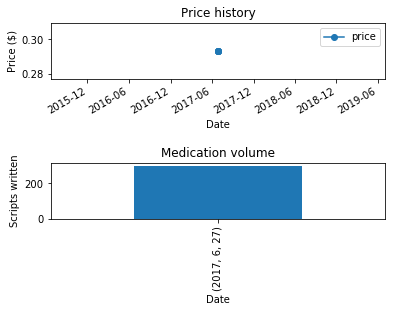

Continue? (Y/N)n


In [17]:
%matplotlib inline
import database
import pandas as pd
import matplotlib.pyplot as plt

meds = database.get_all_medication_records()

for med in meds:
    print(med.name)
    df = pd.DataFrame([{"date":t.date,"price":t.price,"qty":t.qty} for t in med.transactions])
    fig,(ax1,ax2) = plt.subplots(nrows=2)
    df.plot(x="date",y="price",marker='o',ax=ax1)
    ax1.set_title("Price history")
    ax1.set_ylabel("Price ($)")
    ax1.set_xlabel("Date")
    df.groupby([df["date"].dt.year, df["date"].dt.month,df["date"].dt.day])["qty"].sum().plot(kind="bar",ax=ax2)
    ax2.set_title("Medication volume")
    ax2.set_ylabel("Scripts written")
    ax2.set_xlabel("Date")
    fig.subplots_adjust(hspace=1.5)
    plt.show()
    if input("Continue? (Y/N)").lower() != "y":
        break